In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from pathlib import Path
from pprint import pprint
# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# mycode
from repo import REPO
from ml_utilities.output_loader.result_loader import SweepResult, JobResult
from ml_utilities.output_loader import create_job_output_loader
from ml_utilities.output_loader.plot import plot_sweep_summary, plot_data_log_values

# 20 mnist lenet rotatedtasks finetune

**RERUN 11.7.4**: The previous experiment used only pretrained models trained with up to 400 gradient steps. Now we want pretrain longer.

The What is being transferred in transfer learning paper in section "3.5 Which pre-trained checkpoint is most useful for transfer learning?" states that "overall, the benefits from pre-training icnrease as the checkpoint index increases". We want to test this hypothesis as already in their Figure 7 this is not unambiguous. 


## A. Pretraining

### Config file

In [2]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: dragonfly
  gpu_ids: [0]
  runs_per_gpu: 1
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      - run_handler
      notes: null
      group: ${config.experiment_data.experiment_tag}
      job_type: run_handler

seeds: [0]

# sweep:
#   type: grid
#   axes: 
#   - parameter: data.dataset_transforms.enable_transforms
#     vals: [True, False]
    
start_num: 0

config:
  experiment_data:
    entity: fslgroup
    project_name: tflearning
    experiment_tag: '20.0'
    experiment_type: startnum_${start_num}
    experiment_name: mnist-${config.experiment_data.experiment_tag}.${start_num}-lenet-pretrain-0.0
    experiment_dir: null
    experiment_notes: 
    job_name: null
    seed: 0
    hostname: null
    gpu_id: 0
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      notes: ${config.experiment_data.experiment_notes}
      group: ${config.experiment_data.experiment_tag}
      job_type: ${config.experiment_data.experiment_type}

  model:
    model_cfg: lenet_300_100_relu_mnist

  trainer:
    training_setup: supervised
    n_steps: 80e3
    log_train_step_every: 10
    log_additional_logs: true
    val_every: 500
    save_every: 2e3
    save_every_idxes: [0, 50, 100,200,500,1000]
    early_stopping_patience: 80e3
    batch_size: 128
    optimizer_scheduler:
      optimizer_name: AdamW
      optimizer_kwargs:
        lr: 0.001
        weight_decay: 0.0
    loss: crossentropy
    metrics:
    - Accuracy
    num_workers: 4
  
  rot_angle: 0
  data:
    dataset: mnist
    dataset_kwargs:
      data_root_path: /system/user/beck/pwbeck/data
    dataset_split:
      train_val_split: 0.9
    train_split_transforms:
      image_transforms:
      - RandomRotation:
          degrees: ${config.rot_angle}
          interpolation: 2 #bilinear
      tensor_transforms: null
      joint_tensor_transforms: null
    val_split_transforms:
      image_transforms:
      - RandomRotation:
          degrees: ${config.rot_angle}
          interpolation: 2 #bilinear
      tensor_transforms: null
      joint_tensor_transforms: null
"""
cfg = OmegaConf.create(config_yaml)
# OmegaConf.resolve(cfg)

In [3]:
# run_command = REPO.create_experiment(cfg, override=False)
# print(run_command)

### Sweep result

In [4]:
jobr = REPO.get_output_loader(cfg)
jobr

JobResult(/system/user/publicwork/beck/projects/regularization/tflearning/outputs/mnist-20.0.0-lenet-pretrain-0.0--230208_093117)

In [5]:
jobr.get_summary()

,best_train_step,best_val_score,seed
mnist-20.0.0-lenet-pretrain-0.0--230208_093117,49000,0.985,0


In [6]:
jobr.get_data_log(['val'])

,log_step,loss,Accuracy,epoch,train_step
0,0,2.307707,0.101000,0,0
1,557,0.124152,0.962500,2,500
2,1112,0.087526,0.971667,3,1000
3,1666,0.075310,0.976833,4,1500
4,2221,0.080734,0.975500,5,2000
...,...,...,...,...,...
156,86523,0.337014,0.980833,185,78000
157,87079,0.306866,0.982500,187,78500
158,87633,0.296032,0.982167,188,79000
159,88187,0.286610,0.982167,189,79500


In [7]:
dlv = jobr.get_data_log(['train_step','val'])

In [8]:
dlv

,log_step,train_step-loss,train_step-lr,train_step-Accuracy,train_step-weight_norm,train_step-grad_norm,epoch,train_step,val-loss,val-Accuracy
8000,0,NaN,NaN,NaN,NaN,NaN,0,0,2.307707,0.101000
0,12,1.282382e+00,0.001,0.656250,12.043862,1.900262e+00,1,10,NaN,NaN
1,23,6.883647e-01,0.001,0.750000,12.634916,3.146461e+00,1,20,NaN,NaN
2,34,3.939614e-01,0.001,0.890625,13.002606,1.982094e+00,1,30,NaN,NaN
3,45,5.306475e-01,0.001,0.835938,13.201652,2.701086e+00,1,40,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
7996,88708,0.000000e+00,0.001,1.000000,102.748611,4.198319e-09,190,79970,NaN,NaN
7997,88719,6.042982e-06,0.001,1.000000,102.748604,6.010702e-04,190,79980,NaN,NaN
7998,88730,1.490115e-08,0.001,1.000000,102.748604,2.581455e-06,190,79990,NaN,NaN
8160,88742,NaN,NaN,NaN,NaN,NaN,190,80000,0.286362,0.982167


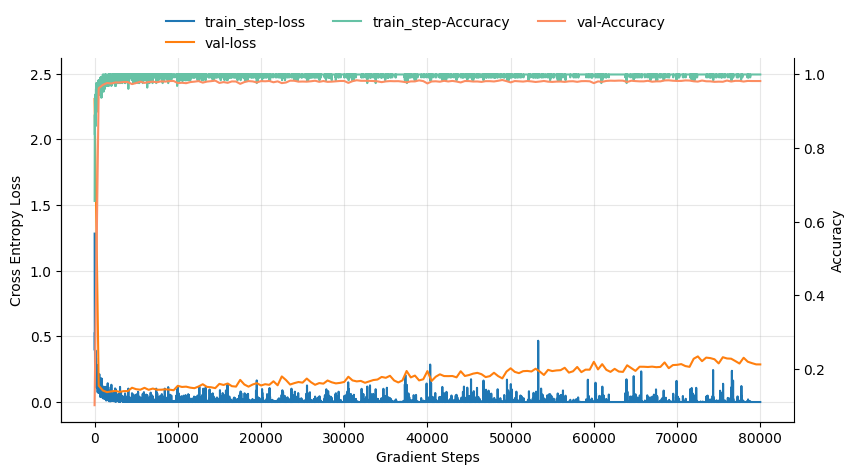

In [9]:
f = plot_data_log_values(dlv,
                         x_axis='train_step',
                         y_axis_left=['train_step-loss', 'val-loss'],
                         y_axis_right=['train_step-Accuracy', 'val-Accuracy'],
                         y_label_left='Cross Entropy Loss',
                         y_label_right='Accuracy',
                         x_label='Gradient Steps',
                         ylim=(-0.15,2.62),
                         figsize=(2 * 12 * 1 / 2.54, 1.5 * 8 * 1 / 2.54))

In [10]:
# failed_jobs = sweepr.get_failed_jobs()
# failed_jobs # No failed jobs

## B. Finetuning

In [11]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: dragonfly
  gpu_ids: [0,1,2,3]
  runs_per_gpu: 4
#   wandb:
#     init:
#       tags:
#       - ${config.experiment_data.experiment_tag}_exps
#       - run_handler
#       notes: null
#       group: ${config.experiment_data.experiment_tag}
#       job_type: run_handler

seeds: [0]

sweep:
  type: grid
  axes: 
  - parameter: rot_angle
    vals: [0, 15, 30, 50, 70, 120]
  - parameter: init_model_step
    vals: [0,50,100,200,500,1000,2000,4000,6000,10000,14000,18000,22000,26000,30000,40000,48000,50000,60000,70000,80000]
    
start_num: 1

config:
  experiment_data:
    entity: fslgroup
    project_name: tflearning
    experiment_tag: '20.1'
    experiment_type: startnum_${start_num}
    experiment_name: mnist-${config.experiment_data.experiment_tag}.${start_num}-lenet-finetune-0.0
    experiment_dir: null
    experiment_notes: 
    job_name: null
    seed: 0
    hostname: null
    gpu_id: 0
  # wandb:
  #   init:
  #     tags:
  #     - ${config.experiment_data.experiment_tag}_exps
  #     notes: ${config.experiment_data.experiment_notes}
  #     group: ${config.experiment_data.experiment_tag}
  #     job_type: ${config.experiment_data.experiment_type}

  init_model_step: 0
  model:
    model_cfg: lenet_300_100_relu_mnist
    init_model: /system/user/beck/pwbeck/projects/regularization/tflearning/outputs/mnist-20.0.0-lenet-pretrain-0.0--230208_093117/checkpoints/checkpoint-train_step--${config.init_model_step}.p

  trainer:
    training_setup: supervised
    n_steps: 20e3 #80e3
    log_train_step_every: 20
    log_additional_logs: true
    val_every: 20
    save_every: 50e3
    save_every_idxes: [0, 50, 100,200,500,1000]
    early_stopping_patience: 5e3
    batch_size: 128
    optimizer_scheduler:
      optimizer_name: AdamW
      optimizer_kwargs:
        lr: 0.001
        weight_decay: 0.0
    loss: crossentropy
    metrics:
    - Accuracy
    num_workers: 4
  
  rot_angle: 0
  data:
    dataset: mnist
    dataset_kwargs:
      data_root_path: /system/user/beck/pwbeck/data
    dataset_split:
      train_val_split: 0.9
      restrict_n_samples_train_task: 300
    train_split_transforms:
      image_transforms:
      - RandomRotation:
          degrees: ${config.rot_angle}
          interpolation: 2 #bilinear
      tensor_transforms: null
      joint_tensor_transforms: null
    val_split_transforms:
      image_transforms:
      - RandomRotation:
          degrees: ${config.rot_angle}
          interpolation: 2 #bilinear
      tensor_transforms: null
      joint_tensor_transforms: null
"""
cfg = OmegaConf.create(config_yaml)

In [12]:
# run_command = REPO.create_experiment(cfg, override=False)
# print(run_command)

In [13]:
sweepr = REPO.get_output_loader(cfg)
print(sweepr)

Exp. Tag(start_num): 20.1(1)
Exp. Name: mnist-20.1.1-lenet-finetune-0.0
Training setup: supervised
Model name: lenet_300_100_relu_mnist
Dataset name: mnist
Sweep type: grid
  rot_angle: [0, 15, 30, 50, 70, 120]
  init_model_step: [0, 50, 100, 200, 500, 1000, 2000, 4000, 6000, 10000, 14000, 18000, 22000, 26000, 30000, 40000, 48000, 50000, 60000, 70000, 80000]
Seeds: [0]
Num. jobs: 126
Config updated: 2023-02-08 10:44:39
Sweep started:  2023-02-08 10:44:57



In [14]:
sw_summary = sweepr.get_summary(log_source='val', row_sel=('train_step', [1000, 5000, 10000]), col_sel='Accuracy')

In [15]:
sw_summary

,best_train_step,best_val_score,Accuracy-train_step-1000,Accuracy-train_step-5000,Accuracy-train_step-10000,rot_angle,init_model_step,seed
mnist-20.1.1-lenet-finetune-0.0--rot_angle-0-init_model_step-0-seed-0--230208_104513,320,0.846667,0.844667,0.843833,0.842333,0,0,0
mnist-20.1.1-lenet-finetune-0.0--rot_angle-0-init_model_step-100-seed-0--230208_104525,0,0.913500,0.899667,0.895000,0.891500,0,100,0
mnist-20.1.1-lenet-finetune-0.0--rot_angle-0-init_model_step-1000-seed-0--230208_104535,0,0.971667,0.962167,0.960500,0.952500,0,1000,0
mnist-20.1.1-lenet-finetune-0.0--rot_angle-0-init_model_step-10000-seed-0--230208_104540,1360,0.977167,0.976833,0.976000,0.975833,0,10000,0
mnist-20.1.1-lenet-finetune-0.0--rot_angle-0-init_model_step-14000-seed-0--230208_104541,4000,0.982667,0.981833,0.982333,0.981667,0,14000,0
...,...,...,...,...,...,...,...,...
mnist-20.1.1-lenet-finetune-0.0--rot_angle-70-init_model_step-50000-seed-0--230208_122000,19200,0.883167,0.855333,0.870167,0.866500,70,50000,0
mnist-20.1.1-lenet-finetune-0.0--rot_angle-70-init_model_step-6000-seed-0--230208_120439,12540,0.889500,0.880500,0.881167,0.882500,70,6000,0
mnist-20.1.1-lenet-finetune-0.0--rot_angle-70-init_model_step-60000-seed-0--230208_122011,17880,0.877000,0.847833,0.858833,0.862833,70,60000,0
mnist-20.1.1-lenet-finetune-0.0--rot_angle-70-init_model_step-70000-seed-0--230208_122015,19080,0.882500,0.853667,0.866167,0.868667,70,70000,0


### Pretrain vs. [Acc, best_step]

We finetune a model pretrained on rotation 0° (54k samples) to other rotations 0°-180° (**300** samples).
We use an early stopping patience of 5000 steps (max. 20e3).

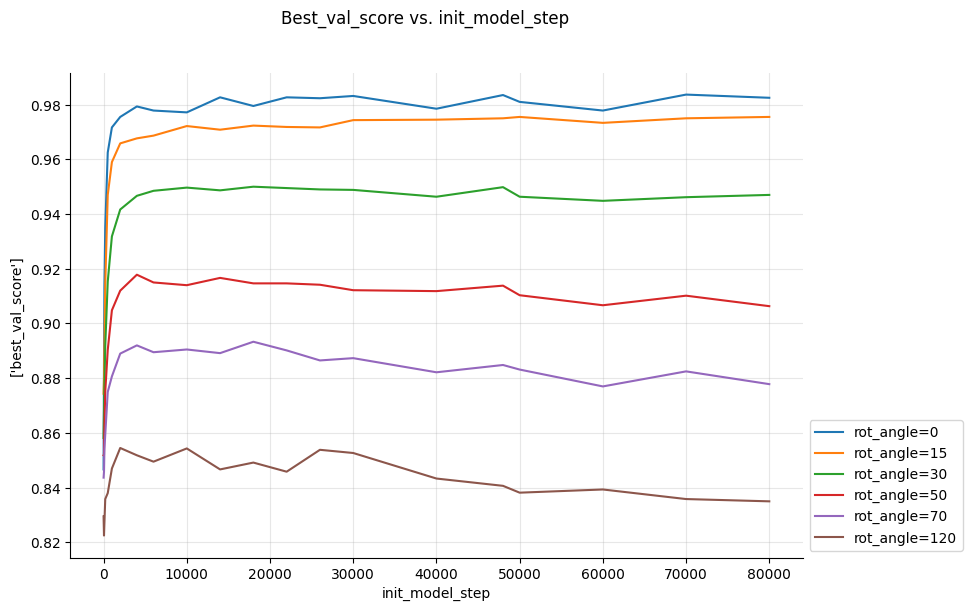

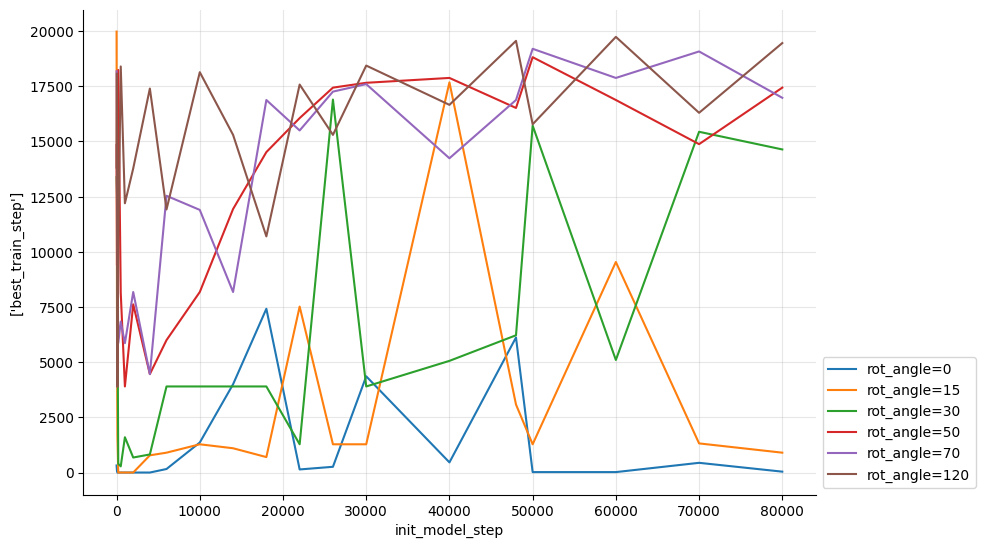

In [19]:
p1 = plot_sweep_summary(sw_summary, x_axis='init_model_step', y_axis='best_val_score', compare_parameter='rot_angle', title='Best_val_score vs. init_model_step', savefig=True)
p2 = plot_sweep_summary(sw_summary, x_axis='init_model_step', y_axis='best_train_step', compare_parameter='rot_angle', savefig=True)

In [17]:
plot_names = ['Accuracy-train_step-1000', 'Accuracy-train_step-5000', 'Accuracy-train_step-10000']

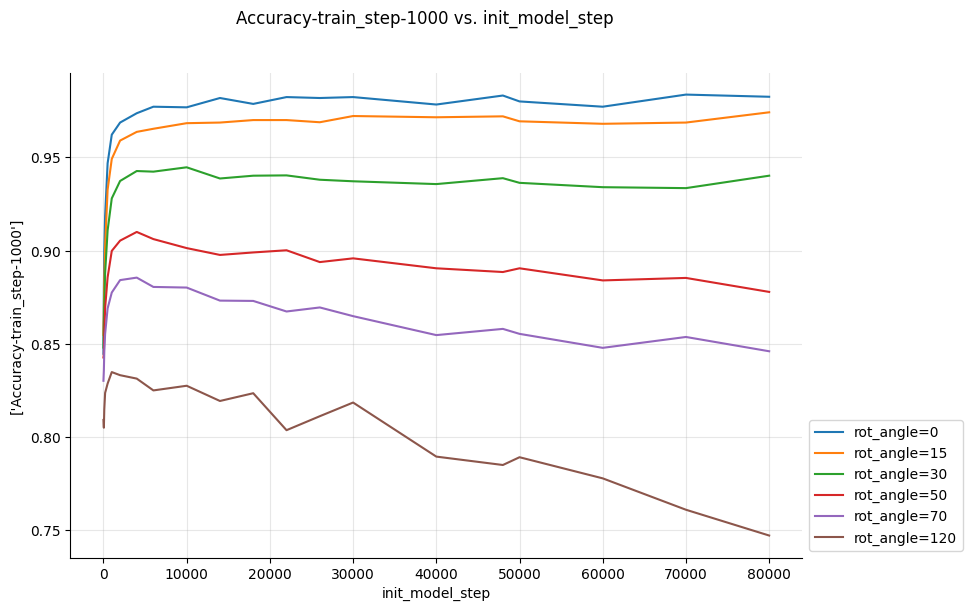

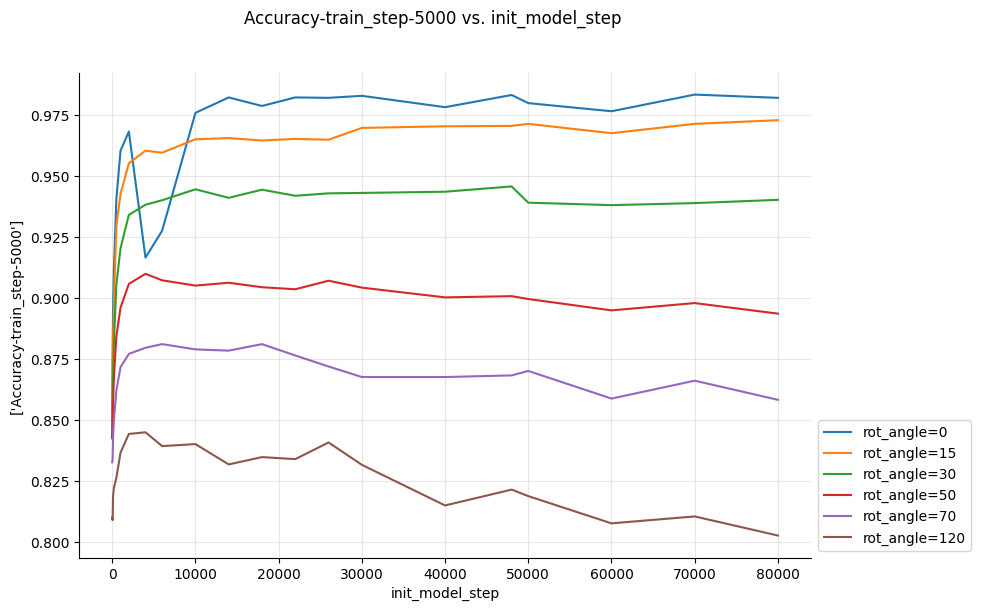

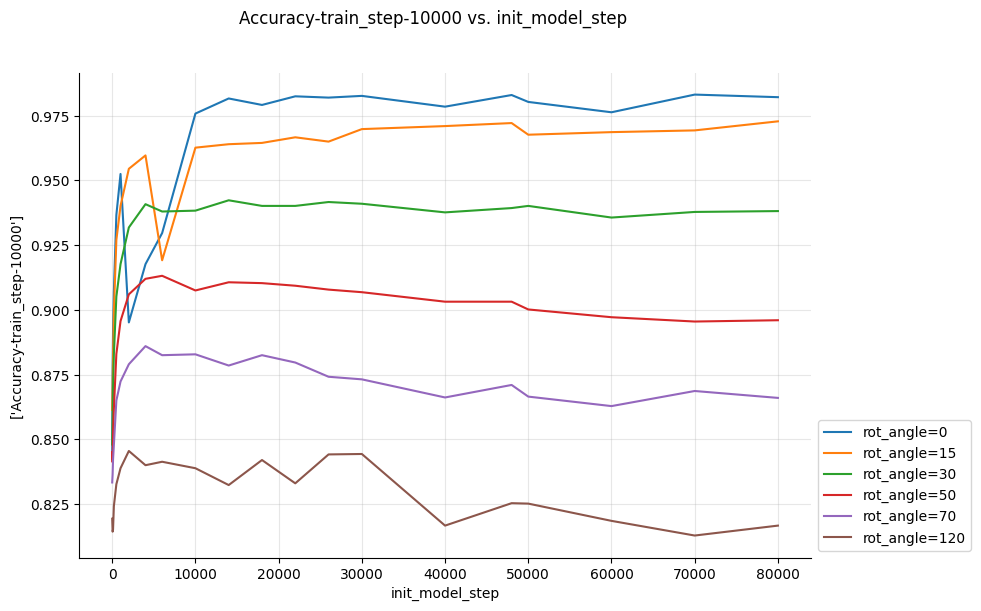

In [18]:
for name in plot_names:
    p = plot_sweep_summary(sw_summary, x_axis='init_model_step', y_axis=name, compare_parameter='rot_angle', title=f'{name} vs. init_model_step', savefig=True) 